# Pb 2 : Similarity / Metric Learning

In [1]:
# Librairies 
import pandas as pd
import numpy as np
from scipy import stats as scs
from scipy import sparse
import matplotlib.pyplot as plt
import seaborn as sns

import re
import random
import time

from Preprocessing_treetagger_v3 import *
from gensim import models, corpora

from sklearn.decomposition import NMF
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn import datasets, linear_model
from sklearn.model_selection import train_test_split, cross_val_score

pd.options.mode.chained_assignment = None
pd.set_option('display.max_columns', 60)

#chemin = "../Data/"

## Load data

In [8]:
# Data labellisées (catégories Innoscape)
df_train = pd.read_excel('../Data/df_train-4.xlsx', sheet_name='Feuil1')

# Selection colonnes pertinentes
columns_to_keep = ['Column1',
                   'productfamily_seller',
                   'productseller_name',
                   'Product_family_innoscape']

df_train = df_train[columns_to_keep]

In [9]:
# Catégorie spécifique
df_test = df_train[df_train['Product_family_innoscape']=='Mastic, colle, étanchéité']
df_test.head()

Column1 productfamily_seller  \
0        0   Colles à carrelage   
1       28   Colles à carrelage   
2       49   Colles à carrelage   
3       63   Colles à carrelage   
4        3               Mastic   

                                  productseller_name  \
0  SikaCeram Xtra - Colle à carrelage intérieur e...   
1  SikaCeram Joint Fin - Mortier pour joint de ca...   
2  SikaCeram Joint Dallage extérieur - Mortier jo...   
3  Colle à carrelage en pâte spéciale carreaux et...   
4              Colle-mastic pour joints d'étanchéité   

    Product_family_innoscape  
0  Mastic, colle, étanchéité  
1  Mastic, colle, étanchéité  
2  Mastic, colle, étanchéité  
3  Mastic, colle, étanchéité  
4  Mastic, colle, étanchéité

In [10]:
print("Dimension sur Mastic, colle, étanchéité : ", df_test.shape)

Dimension sur Mastic, colle, étanchéité :  (329, 4)


In [11]:
df_test2 = df_train[df_train['Product_family_innoscape']=='Perceuse, perforateur et visseuse sans fil']
df_test2.head()

Column1 productfamily_seller  \
12        6    Perceuse-visseuse   
13       79    Perceuse-visseuse   
14      161    Perceuse-visseuse   
15      203    Perceuse-visseuse   
48       25  Marteau perforateur   

                                   productseller_name  \
12  Perceuse-visseuse RYOBI 18V OnePlus - 1 batter...   
13            Ryobi 5133001929 Perceuse sans fil 18 V   
14  AEG BBS 12C2-LI 202C Perceuse Simple Électriqu...   
15  AEG visseuse à percussion sans fil BSB 18 G2/1...   
48  AEG Powertools Marteau Perforateur BBH 18 (PRO...   

                      Product_family_innoscape  
12  Perceuse, perforateur et visseuse sans fil  
13  Perceuse, perforateur et visseuse sans fil  
14  Perceuse, perforateur et visseuse sans fil  
15  Perceuse, perforateur et visseuse sans fil  
48  Perceuse, perforateur et visseuse sans fil

In [12]:
print("Dimension sur Perceuse.. sans fil : ", df_test2.shape)

Dimension sur Perceuse.. sans fil :  (62, 4)


## Preprocessing

In [13]:
# Caractères spéciaux
dico1 = {",":" ", "'":" ", ";":" ", ":":" ", "\?":" ", "!":" ", "\.":'', "  ":" ", "  ":" ",
         "\(":"","\)":"","\[":"","\]":"","-":" ","\+":"","/":"","\*":"","–":" ",
         "&":"et"}

# Caractères avec accents
dico2 = {'à':'a','â':'a','ä':'a',
              'é':'e','è':'e','ê':'e','ë':'e',
              'ï':'i','î':'i',
              'ô':'o','ö':'o',
              'ù':'u','û':'u',
              'ç':'c'}

In [14]:
# Stop words & marques
stop_words = {'a',
             'ai',
             'aie',
             'aient',
             'aies',
             'ait',
             'as',
             'au',
             'aura',
             'aurai',
             'auraient',
             'aurais',
             'aurait',
             'auras',
             'aurez',
             'auriez',
             'aurions',
             'aurons',
             'auront',
             'aux',
             'avaient',
             'avais',
             'avait',
             'avec',
             'avez',
             'aviez',
             'avions',
             'avons',
             'ayant',
             'ayante',
             'ayantes',
             'ayants',
             'ayez',
             'ayons',
             'c',
             'ce',
             'ces',
             'd',
             'dans',
             'de',
             'des',
             'du',
             'elle',
             'en',
             'es',
             'est',
             'et',
             'eu',
             'eue',
             'eues',
             'eurent',
             'eus',
             'eusse',
             'eussent',
             'eusses',
             'eussiez',
             'eussions',
             'eut',
             'eux',
             'eûmes',
             'eût',
             'eûtes',
             'furent',
             'fus',
             'fusse',
             'fussent',
             'fusses',
             'fussiez',
             'fussions',
             'fut',
             'fûmes',
             'fût',
             'fûtes',
             'il',
             'j',
             'je',
             'l',
             'la',
             'le',
             'leur',
             'lui',
             'm',
             'ma',
             'mais',
             'me',
             'mes',
             'moi',
             'mon',
             'même',
             'n',
             'ne',
             'nos',
             'notre',
             'nous',
             'on',
             'ont',
             'ou',
             'par',
             'pas',
             'pour',
             'qu',
             'que',
             'qui',
             's',
             'sa',
             'se',
             'sera',
             'serai',
             'seraient',
             'serais',
             'serait',
             'seras',
             'serez',
             'seriez',
             'serions',
             'serons',
             'seront',
             'ses',
             'soient',
             'sois',
             'soit',
             'sommes',
             'son',
             'sont',
             'soyez',
             'soyons',
             'suis',
             'sur',
             't',
             'ta',
             'te',
             'tes',
             'toi',
             'ton',
             'tu',
             'un',
             'une',
             'vos',
             'votre',
             'vous',
             'y',
             'à',
             'étaient',
             'étais',
             'était',
             'étant',
             'étante',
             'étantes',
             'étants',
             'étiez',
             'étions',
             'été',
             'étée',
             'étées',
             'étés',
             'êtes',
             ',',
             '(',
             ')',
             '[',
             ']',
             '-',
             '/',
             '+',
             '*',
             '{',
             '}',
             '!',
             ';',
             ':',
             '?',
             '.',
             '&'
             }


#marques =  set(open('../Data/marques.txt').read().split())

#stop_words = stop_words.union(marques)

In [15]:
# Preprocessing 
df_test = preprocessing(df_test, ['productfamily_seller', 'productseller_name'], dico1, dico2, stop_words, '/Users/valentinphetchanpheng/Downloads/treetagger')
df_test['info'] = df_test.productfamily_seller_clean + ' ' + df_test.productseller_name_clean

columns_to_keep = ['Column1',
                   'productfamily_seller',
                   'productseller_name',
                   'Product_family_innoscape',
                   'info']

df_test = df_test[columns_to_keep]

In [16]:
# Preprocessing
df_test2 = preprocessing(df_test2, ['productfamily_seller', 'productseller_name'], dico1, dico2, stop_words, '/Users/valentinphetchanpheng/Downloads/treetagger')
df_test2['info'] = df_test2.productfamily_seller_clean + ' ' + df_test2.productseller_name_clean
#df_test2 = preprocessing(df_test2, ['productseller_name'], dico1, dico2, stop_words, '/Users/valentinphetchanpheng/Downloads/treetagger')
#df_test2['info'] = df_test2.productseller_name_clean

columns_to_keep = ['Column1',
                   'productfamily_seller',
                   'productseller_name',
                   'Product_family_innoscape',
                   'info']

df_test2 = df_test2[columns_to_keep]

In [17]:
df_test[df_test['productfamily_seller'].str.contains('Peinture')].head(20)

Column1                productfamily_seller  \
799      4462  Peinture et traitements extérieurs   
846      4587                            Peinture   
913      9200                   Peinture matériel   
914      9204                   Peinture matériel   
915      9205                   Peinture matériel   
916      9207                   Peinture matériel   
919      9299                  Peinture entretien   
920      9361                  Peinture entretien   
921      9439                  Peinture entretien   
922      9458                  Peinture entretien   
1619    16794        Peinture pour forte humidité   
1620    18221        Peinture pour forte humidité   
1950    20750          Mastics Adhésifs Peintures   

                                     productseller_name  \
799    SIKA Imperméabilisant pour sol   Effet Mat   5 L   
846   SIKA Kit d étanchéité pour douche   A l italienne   
913   Sikagard Protection Toiture inclinée   contre ...   
914   SIKA 7301 SIKAFLEX 11 FC MASTIC COLLE MULTIUSA...   
915   SIKA 55059 SIKAFLEX 11 FC MASTIC COLLE MULTIUS...   
916   Sika 515311 Non Staining Construction Sealant ...   
919   Mastic pour façades en béton et maçonnerie SIK...   
920   Mastic pour façades en béton et maçonnerie SIK...   
921   Mastic colle à prise rapide SIKA Sikaflex G 13...   
922   Mastic pour façades en béton et maçonnerie SIK...   
1619  Kit Pro anti humidité SIKA SikaMur InjectoCrea...   
1620  Kit Pro anti humidité SIKA SikaMur InjectoCrea...   
1950     Adhésif de masquage lisse 50 m x 48 mm Novipro   

       Product_family_innoscape  \
799   Mastic, colle, étanchéité   
846   Mastic, colle, étanchéité   
913   Mastic, colle, étanchéité   
914   Mastic, colle, étanchéité   
915   Mastic, colle, étanchéité   
916   Mastic, colle, étanchéité   
919   Mastic, colle, étanchéité   
920   Mastic, colle, étanchéité   
921   Mastic, colle, étanchéité   
922   Mastic, colle, étanchéité   
1619  Mastic, colle, étanchéité   
1620  Mastic, colle, étanchéité   
1950  Mastic, colle, étanchéité   

                                                   info  
799   exterieur peinture traitement impermeabiliser ...  
846   peinture italien avoir douche etancheite kit sika  
913   materiel peinture contre sikagard fuite toitur...  
914   materiel peinture sikaflex multiusage coller m...  
915   materiel peinture sikaflex multiusage coller m...  
916   materiel peinture construction staining sealan...  
919   entretien peinture maconnerie construction bet...  
920   entretien peinture maconnerie construction bet...  
921   entretien peinture sikaflex beton gris colle p...  
922   entretien peinture maconnerie construction bet...  
1619  humidite fort peinture anti humidite injectocr...  
1620  humidite fort peinture anti humidite injectocr...  
1950  mastic peinture adhesif adhesif masquage novip...

## Word Embedding

In [18]:
vectorizer = TfidfVectorizer(lowercase=False)
tf_idf_total = sparse.csr_matrix(vectorizer.fit_transform(df_test["info"]))
tfidf_feature_names = vectorizer.get_feature_names()

nmf = NMF(n_components=200, random_state=1, alpha=.1, l1_ratio=.5).fit(tf_idf_total)

In [19]:
print('Taille vocabulaire tf-idf : ', len(tfidf_feature_names))

Taille vocabulaire tf-idf :  390


In [20]:
X = pd.DataFrame(nmf.transform(tf_idf_total)).set_index(df_test.index.values)

In [21]:
vectorizer2 = TfidfVectorizer(lowercase=False)
tf_idf_total2 = sparse.csr_matrix(vectorizer2.fit_transform(df_test2["info"]))
tfidf_feature_names2 = vectorizer2.get_feature_names()

nmf2 = NMF(n_components=50, random_state=1,
          alpha=.1, l1_ratio=.5).fit(tf_idf_total2)

X2 = pd.DataFrame(nmf2.transform(tf_idf_total2)).set_index(df_test2.index.values)

## Model pour etiquettage des données

### Méthode Clustering

In [22]:
from sklearn.cluster import KMeans
from scipy.spatial.distance import cdist

# Methode du coude pour trouver k (nombre de cluster) optimal
def elbow_method(X, K):
    # k means determine k
    distortions = []
    for k in K:
        kmeanModel = KMeans(n_clusters=k).fit(X)
        kmeanModel.fit(X)
        distortions.append(sum(np.min(cdist(X, kmeanModel.cluster_centers_, 'euclidean'), axis=1)) / X.shape[0])
        
    # Plot the elbow
    plt.figure(figsize=(8,6))
    plt.plot(K, distortions, 'bx-')
    plt.xlabel('k')
    plt.ylabel('Distortion')
    plt.title('Elbow Method showing the optimal k')
    plt.show()

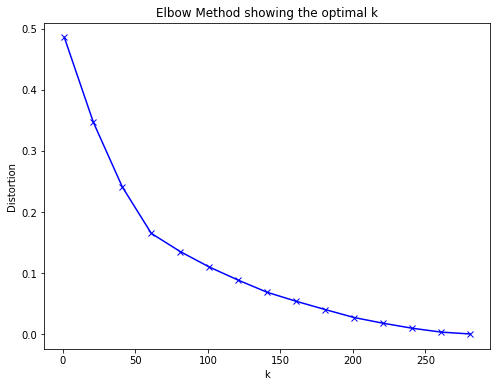

In [23]:
elbow_method(X, range(1,300, 20))

In [178]:
model = KMeans(n_clusters=70, init='k-means++', max_iter=100, n_init=1)
model.fit(X)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=100,
    n_clusters=70, n_init=1, n_jobs=None, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)

In [179]:
test = df_test.copy()
test['label'] = model.labels_

In [180]:
test[test['productfamily_seller'].str.contains('Peinture')].head(20)

Column1                productfamily_seller  \
799      4462  Peinture et traitements extérieurs   
846      4587                            Peinture   
913      9200                   Peinture matériel   
914      9204                   Peinture matériel   
915      9205                   Peinture matériel   
916      9207                   Peinture matériel   
919      9299                  Peinture entretien   
920      9361                  Peinture entretien   
921      9439                  Peinture entretien   
922      9458                  Peinture entretien   
1619    16794        Peinture pour forte humidité   
1620    18221        Peinture pour forte humidité   
1950    20750          Mastics Adhésifs Peintures   

                                     productseller_name  \
799    SIKA Imperméabilisant pour sol   Effet Mat   5 L   
846   SIKA Kit d étanchéité pour douche   A l italienne   
913   Sikagard Protection Toiture inclinée   contre ...   
914   SIKA 7301 SIKAFLEX 11 FC MASTIC COLLE MULTIUSA...   
915   SIKA 55059 SIKAFLEX 11 FC MASTIC COLLE MULTIUS...   
916   Sika 515311 Non Staining Construction Sealant ...   
919   Mastic pour façades en béton et maçonnerie SIK...   
920   Mastic pour façades en béton et maçonnerie SIK...   
921   Mastic colle à prise rapide SIKA Sikaflex G 13...   
922   Mastic pour façades en béton et maçonnerie SIK...   
1619  Kit Pro anti humidité SIKA SikaMur InjectoCrea...   
1620  Kit Pro anti humidité SIKA SikaMur InjectoCrea...   
1950     Adhésif de masquage lisse 50 m x 48 mm Novipro   

       Product_family_innoscape  \
799   Mastic, colle, étanchéité   
846   Mastic, colle, étanchéité   
913   Mastic, colle, étanchéité   
914   Mastic, colle, étanchéité   
915   Mastic, colle, étanchéité   
916   Mastic, colle, étanchéité   
919   Mastic, colle, étanchéité   
920   Mastic, colle, étanchéité   
921   Mastic, colle, étanchéité   
922   Mastic, colle, étanchéité   
1619  Mastic, colle, étanchéité   
1620  Mastic, colle, étanchéité   
1950  Mastic, colle, étanchéité   

                                                   info  label  
799   exterieur peinture traitement impermeabiliser ...     63  
846   peinture italien avoir douche etancheite kit sika      4  
913   materiel peinture contre sikagard fuite toitur...      5  
914   materiel peinture sikaflex multiusage coller m...     44  
915   materiel peinture sikaflex multiusage coller m...     44  
916   materiel peinture construction staining sealan...     18  
919   entretien peinture maconnerie construction bet...     30  
920   entretien peinture maconnerie construction bet...     30  
921   entretien peinture sikaflex beton gris colle p...     18  
922   entretien peinture maconnerie construction bet...     30  
1619  humidite fort peinture anti humidite injectocr...     14  
1620  humidite fort peinture anti humidite injectocr...     14  
1950  mastic peinture adhesif adhesif masquage novip...     48

In [149]:
test.sort_values('label')

Column1                            productfamily_seller  \
9         186                                           Cires   
19        255                           Produits d étanchéité   
18        250                           Produits d étanchéité   
16          7                           Produits d étanchéité   
1683    17530                            Ruban adhésif divers   
1950    20750                      Mastics Adhésifs Peintures   
694      4376                                         Adhésif   
693      3054                                         Adhésif   
78        150                             Colles universelles   
1726    18491                              Etanchéité Toiture   
707      3628                        Etanchéité de la toiture   
354      1041                  Étanchéité toiture et terrasse   
1185    15704                              Mastic de fixation   
1089    10312                Etanchéité des sols et terrasses   
1809    18677                             Enduit d étanchéité   
1780    18490                               Etanchéité Douche   
1634    16937        Kit d étanchéité pour receveur de douche   
846      4587                                        Peinture   
1102    10223  Etanchéité des fondations mur enterré et dalle   
1105    10472  Etanchéité des fondations mur enterré et dalle   
1103    10314  Etanchéité des fondations mur enterré et dalle   
1671    17431                               Colle multi usage   
925      9538                                  Revêtement sol   
1430    15927       Produit d étanchéité pour sol et terrasse   
1218    15671               Produit d étanchéité pour toiture   
1220    16910               Produit d étanchéité pour toiture   
1194    15648                                   Colle parquet   
1729    18448                              Colle pour parquet   
1730    18484                              Colle pour parquet   
1731    18522                              Colle pour parquet   
...       ...                                             ...   
166       793                        Ruban adhésif industriel   
163       216                        Ruban adhésif industriel   
164       287                        Ruban adhésif industriel   
1816    18688                             Mastic multi usages   
1747    18459                             Mastic polyuréthane   
1743    18497                                       Hydrofuge   
795      4461                                  Etanchéité mur   
331       900                             Cartouche et Mastic   
1759    18628                               Mortier Hydrofuge   
318       889            Etanchéité extérieure et Anti mousse   
1346    15816     Produit d étanchéité pour fondation et cave   
414      2509                                           Colle   
1770    18504                                Mastic acrylique   
5          57                                          Mastic   
817      4478                            Matériel de chantier   
913      9200                               Peinture matériel   
917      9201                              Outils électriques   
450      2462                                  Colle et joint   
1771    18580                                Mastic acrylique   
1768    18469                                Mastic acrylique   
1769    18472                                Mastic acrylique   
939      9610                                Colles Acrylique   
673      2895                                Colle et adhésif   
1432    16835       Produit d étanchéité pour sol et terrasse   
926      9554                                  Revêtement sol   
927      9561                                  Revêtement sol   
1431    16144       Produit d étanchéité pour sol et terrasse   
1182    15645                              Mastic de fixation   
449      2451                                  Colle et joint   
480      2488                       Carto

In [164]:
from sklearn.manifold import TSNE

# Fonction pour visualization TSNE
def tsne(X, y, n_components, perplexity):
    time_start = time.time()
    X_tsne = TSNE(n_components=n_components, perplexity=perplexity, init='pca').fit_transform(X)
    print('t-SNE done! Time elapsed: {} seconds'.format(time.time()-time_start))
    
    plt.figure(figsize=(8, 6))
    plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=y)
    plt.show()

t-SNE done! Time elapsed: 2.201970338821411 seconds


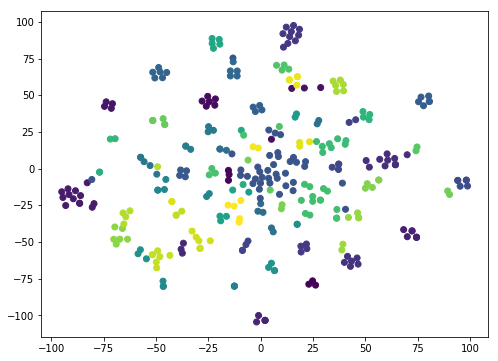

In [181]:
tsne(X, model.labels_, 2, 15)

/anaconda3/envs/python36/lib/python3.6/site-packages/sklearn/cluster/k_means_.py:968: ConvergenceWarning: Number of distinct clusters (60) found smaller than n_clusters (61). Possibly due to duplicate points in X.
  return_n_iter=True)


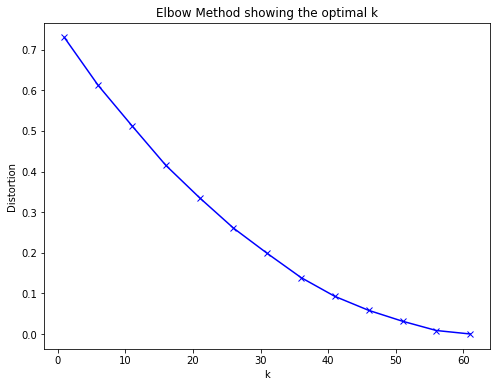

In [30]:
elbow_method(X2, range(1,65, 5))

In [31]:
model2 = KMeans(n_clusters=45, init='k-means++', max_iter=100, n_init=1)
model2.fit(X2)

test2 = df_test2.copy()
test2['label'] = model2.labels_

In [32]:
test2.sort_values('label')

Column1                               productfamily_seller  \
202       553                             Perceuses à percussion   
1271    17942                                        Clé à chocs   
1268    15733                                        Clé à chocs   
404      2428                     Perforateur et marteau piqueur   
403      2422                     Perforateur et marteau piqueur   
406      2448                     Perforateur et marteau piqueur   
219       313                            Perceuses à angle droit   
786      4446                                           Perceuse   
225       347                       Perceuses à poignée pistolet   
541      2592                                          Tournevis   
540      2516                                          Tournevis   
1092    10358                      Perceuse sans fil et visseuse   
1410    15885                   Visseuse et tournevis électrique   
1413    18153                   Visseuse et tournevis électrique   
132       182                                    Perceuses combi   
130       138                                    Perceuses combi   
1347    15824                        Visseuse à plaque de plâtre   
1348    17816                        Visseuse à plaque de plâtre   
527      2713  Perceuse visseuse perceuse à percussion et tou...   
791      4472                                           Meuleuse   
792      4582                                           Meuleuse   
790      4447                                           Meuleuse   
526      2707  Perceuse visseuse perceuse à percussion et tou...   
15        203                                  Perceuse visseuse   
1093    10394                      Perceuse sans fil et visseuse   
525      2599  Perceuse visseuse perceuse à percussion et tou...   
51        129                                Marteau perforateur   
408      2426                         Perceuse visseuse sans fil   
409      2442                         Perceuse visseuse sans fil   
1437    16954                                   Visseuse à chocs   
...       ...                                                ...   
14        161                                  Perceuse visseuse   
200       288                             Perceuses à percussion   
60         71                                  Packs de batterie   
201       550                             Perceuses à percussion   
12          6                                  Perceuse visseuse   
1091    10341                      Perceuse sans fil et visseuse   
1411    17079                   Visseuse et tournevis électrique   
789      4496                                           Perceuse   
1412    17637                   Visseuse et tournevis électrique   
793      4599                                           Meuleuse   
543      2667                                          Tournevis   
410      2452                         Perceuse visseuse sans fil   
1435    16320                                   Visseuse à chocs   
405      2444                     Perforateur et marteau piqueur   
180       265                       Perceuses à colonne d établi   
407      2423                         Perceuse visseuse sans fil   
542      2624                                          Tournevis   
1090    10214                      Perceuse sans fil et visseuse   
49        119                                Marteau perforateur   
48         25                                Marteau perforateur   
1434    15934                                   Visseuse à chocs   
787      4454                                           Perceuse   
1436    16694                                   Visseuse à chocs   
133       662                                    Perceuses combi   
788      4487                                           Perceuse   
524      2501  Perceuse visseuse perceuse à percussion et tou...   
203       554                             Perceuses à percussi

## Metric Learning

In [36]:
import metric_learn

In [182]:
y = pd.DataFrame({'label' : model.labels_})

In [183]:
# Train test split
X_bis = X.copy()
X_bis['label'] = model.labels_
X_train, X_test, y_train, y_test = train_test_split(X_bis, y, test_size=0.2, random_state=22)

In [184]:
# On retire les produits qui n'ont pas au moins une paire (valeur variable) Xtrain / Xtest
cond = y_train['label'].value_counts() < 2
label_to_remove = cond[cond==True].index

X_label = X_train.copy()
X_label = X_label[~X_label['label'].isin(label_to_remove)]

y_label = X_label['label']
X_label = X_label.drop('label', axis=1)

X_test = X_test.drop('label', axis=1)

In [53]:
# On retire les produits qui n'ont pas au moins une paire (valeur variable)
#cond = y['label'].value_counts() < 2
#label_to_remove = cond[cond==True].index

#X_label = X.copy()
#X_label['label'] = model.labels_
#X_label = X_label[~X_label['label'].isin(label_to_remove)]

#y_label = X_label['label']
#X_label = X_label.drop('label', axis=1)

In [185]:
print('Dimension train set : ', X_label.shape)
print('Dimension test set : ', X_test.shape)

Dimension train set :  (250, 200)
Dimension test set :  (66, 200)


#### LMNN

In [186]:
# Model LMNN
lmnn = metric_learn.LMNN(k = 2, learn_rate=1e-6)

# Fit the data
lmnn.fit(X_label, y_label)

# Metric learned
print(lmnn.metric())

/anaconda3/envs/python36/lib/python3.6/site-packages/metric_learn/lmnn.py:62: UserWarning: use_pca does nothing for the python_LMNN implementation
  warnings.warn('use_pca does nothing for the python_LMNN implementation')


[[ 1.12089963e+01 -7.20517837e-01 -9.76257185e-01 ...  0.00000000e+00
  -3.19010233e-02  3.95003627e-01]
 [-7.20517837e-01  1.33799679e+01  3.49990522e+00 ...  0.00000000e+00
   1.41172727e-02  3.54700538e-03]
 [-9.76257185e-01  3.49990522e+00  1.09930359e+01 ...  0.00000000e+00
   1.97519590e-02 -5.60566554e-03]
 ...
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ...  1.00000000e+00
   0.00000000e+00  0.00000000e+00]
 [-3.19010233e-02  1.41172727e-02  1.97519590e-02 ...  0.00000000e+00
   8.76192156e+00  1.36835136e-02]
 [ 3.95003627e-01  3.54700538e-03 -5.60566554e-03 ...  0.00000000e+00
   1.36835136e-02  4.74989536e+00]]


In [187]:
X_lmnn = lmnn.transform()

t-SNE done! Time elapsed: 1.7605361938476562 seconds


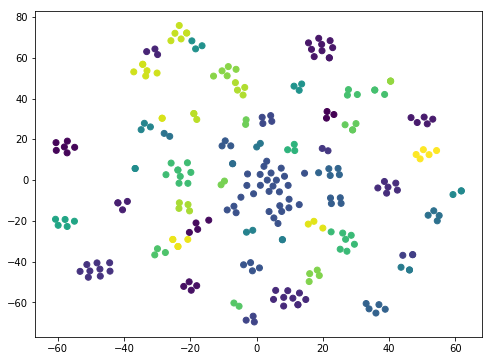

In [188]:
tsne(X_lmnn, y_label, 2, 15)

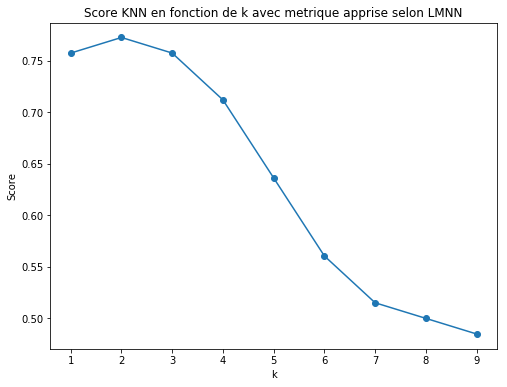

In [189]:
from sklearn.neighbors import KNeighborsClassifier

score = []
K = range(1,10)
for k in K:
    # Fit the nearest neighbors classifier
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(lmnn.transform(X_label), y_label)

    # Compute the k-nearest neighbor test accuracy after applying the learned transformation
    lmnn_acc = knn.score(lmnn.transform(X_test), y_test)
    score.append(lmnn_acc)
    #print('LMNN accuracy on test set of {} points: {:.4f}'.format(X_test.shape[0], lmnn_acc))
    
    
# Plot 
plt.figure(figsize=(8,6))
plt.plot(K, score, 'o-')
plt.xlabel('k')
plt.ylabel('Score')
plt.title('Score KNN en fonction de k avec metrique apprise selon LMNN')
plt.show()


In [191]:
knn = KNeighborsClassifier(n_neighbors=2)
knn.fit(lmnn.transform(X_label), y_label)
y_pred = knn.predict(lmnn.transform(X_test))
lmnn_acc = knn.score(lmnn.transform(X_test), y_test)
print('LMNN accuracy on test set of {} points: {:.4f}'.format(X_test.shape[0], lmnn_acc))

LMNN accuracy on test set of 66 points: 0.7727


In [192]:
index_test = X_test.index
prediction = df_test.loc[index_test].copy()
prediction['label'] = y_pred
prediction['true_label'] = test.loc[index_test]['label']
prediction.sort_values('true_label')

Column1                            productfamily_seller  \
779      4449                                          mastic   
1228    15684                            Rouleau d étanchéité   
706      3365                        Etanchéité de la toiture   
1219    16772               Produit d étanchéité pour toiture   
1481    16057             Protection et rénovation de toiture   
16          7                           Produits d étanchéité   
19        255                           Produits d étanchéité   
1828    18693                   Colle pour parquet et lambris   
1671    17431                               Colle multi usage   
1770    18504                                Mastic acrylique   
1857    18833                              Etanchéité liquide   
1856    18832                              Etanchéité liquide   
318       889            Etanchéité extérieure et Anti mousse   
1775    18541                         Traitement humidité mur   
1545    16216                       Colle et mastic de marine   
1430    15927       Produit d étanchéité pour sol et terrasse   
1431    16144       Produit d étanchéité pour sol et terrasse   
366      1369                                         Mastics   
315       864            Etanchéité extérieure et Anti mousse   
1842    18774                          Mastic de construction   
1616    16750                                Colle spécifique   
316       871            Etanchéité extérieure et Anti mousse   
1628    16874                Poudre à tracer et spray traceur   
1593    16560          Support et fixation de panneau solaire   
354      1041                  Étanchéité toiture et terrasse   
111       179                                       Silicones   
113       798                                       Silicones   
1401    16866            Mastic pour cuisine et salle de bain   
1968    30846                        Isolation mur spécifique   
279       748                                         Enduits   
...       ...                                             ...   
920      9361                              Peinture entretien   
957      9585                                          Divers   
1762    18646                             Etanchéité Terrasse   
1746    18456                             Mastic polyuréthane   
1759    18628                               Mortier Hydrofuge   
1756    18458                               Mortier Hydrofuge   
669      2853                              Colle pour isolant   
915      9205                               Peinture matériel   
1102    10223  Etanchéité des fondations mur enterré et dalle   
1230    15749                            Rouleau d étanchéité   
947      9544                             Colles polyuréthane   
1847    18803                           Revêtement sol et mur   
1683    17530                            Ruban adhésif divers   
900      5008                                  Adhésif  Colle   
479      2474                       Cartouche mastic et joint   
333       953                             Cartouche et Mastic   
1904    21309                             Bandes d étanchéité   
944      9606                              Bande d étanchéité   
695      4560                                         Adhésif   
1818    18713                             Mastic multi usages   
1064    10299                  Etanchéité des murs et façades   
1902    19016                             Bandes d étanchéité   
781      4451                                          mastic   
365      1368                                         Mastics   
1272    15736                          Mastic spécial piscine   
1742    18477                                       Hydrofuge   
799      4462              Peinture et traitements extérieurs   
1772    18471                         Traitement humidité mur   
1877    18888                              Mastics étanchéité   
930      9523                            

#### ITML

In [199]:
itml = metric_learn.ITML_Supervised(num_constraints=200)
X_itml = itml.fit_transform(X_label, y_label)

t-SNE done! Time elapsed: 1.7241599559783936 seconds


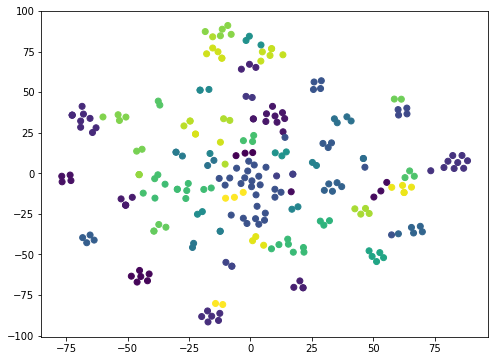

In [200]:
tsne(X_itml, y_label, 2, 15)

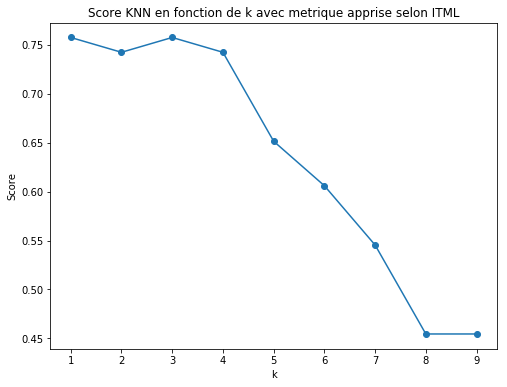

In [205]:
score = []
K = range(1,10)
for k in K:
    # Fit the nearest neighbors classifier
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(itml.transform(X_label), y_label)

    # Compute the k-nearest neighbor test accuracy after applying the learned transformation
    lmnn_acc = knn.score(itml.transform(X_test), y_test)
    score.append(lmnn_acc)

    
# Plot 
plt.figure(figsize=(8,6))
plt.plot(K, score, 'o-')
plt.xlabel('k')
plt.ylabel('Score')
plt.title('Score KNN en fonction de k avec metrique apprise selon ITML')
plt.show()

In [206]:
knn = KNeighborsClassifier(n_neighbors=3)
knn.fit(itml.transform(X_label), y_label)
y_pred2 = knn.predict(itml.transform(X_test))
itml_acc = knn.score(itml.transform(X_test), y_test)
print('LMNN accuracy on test set of {} points: {:.4f}'.format(X_test.shape[0], itml_acc))

LMNN accuracy on test set of 66 points: 0.7576


In [207]:
prediction2 = df_test.loc[index_test].copy()
prediction2['label'] = y_pred2
prediction2['true_label'] = test.loc[index_test]['label']
prediction.sort_values('true_label')

Column1                            productfamily_seller  \
779      4449                                          mastic   
1228    15684                            Rouleau d étanchéité   
706      3365                        Etanchéité de la toiture   
1219    16772               Produit d étanchéité pour toiture   
1481    16057             Protection et rénovation de toiture   
16          7                           Produits d étanchéité   
19        255                           Produits d étanchéité   
1828    18693                   Colle pour parquet et lambris   
1671    17431                               Colle multi usage   
1770    18504                                Mastic acrylique   
1857    18833                              Etanchéité liquide   
1856    18832                              Etanchéité liquide   
318       889            Etanchéité extérieure et Anti mousse   
1775    18541                         Traitement humidité mur   
1545    16216                       Colle et mastic de marine   
1430    15927       Produit d étanchéité pour sol et terrasse   
1431    16144       Produit d étanchéité pour sol et terrasse   
366      1369                                         Mastics   
315       864            Etanchéité extérieure et Anti mousse   
1842    18774                          Mastic de construction   
1616    16750                                Colle spécifique   
316       871            Etanchéité extérieure et Anti mousse   
1628    16874                Poudre à tracer et spray traceur   
1593    16560          Support et fixation de panneau solaire   
354      1041                  Étanchéité toiture et terrasse   
111       179                                       Silicones   
113       798                                       Silicones   
1401    16866            Mastic pour cuisine et salle de bain   
1968    30846                        Isolation mur spécifique   
279       748                                         Enduits   
...       ...                                             ...   
920      9361                              Peinture entretien   
957      9585                                          Divers   
1762    18646                             Etanchéité Terrasse   
1746    18456                             Mastic polyuréthane   
1759    18628                               Mortier Hydrofuge   
1756    18458                               Mortier Hydrofuge   
669      2853                              Colle pour isolant   
915      9205                               Peinture matériel   
1102    10223  Etanchéité des fondations mur enterré et dalle   
1230    15749                            Rouleau d étanchéité   
947      9544                             Colles polyuréthane   
1847    18803                           Revêtement sol et mur   
1683    17530                            Ruban adhésif divers   
900      5008                                  Adhésif  Colle   
479      2474                       Cartouche mastic et joint   
333       953                             Cartouche et Mastic   
1904    21309                             Bandes d étanchéité   
944      9606                              Bande d étanchéité   
695      4560                                         Adhésif   
1818    18713                             Mastic multi usages   
1064    10299                  Etanchéité des murs et façades   
1902    19016                             Bandes d étanchéité   
781      4451                                          mastic   
365      1368                                         Mastics   
1272    15736                          Mastic spécial piscine   
1742    18477                                       Hydrofuge   
799      4462              Peinture et traitements extérieurs   
1772    18471                         Traitement humidité mur   
1877    18888                              Mastics étanchéité   
930      9523                            